# DQN

# Import the Libraries

In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.optimize import minimize

from PortfolioRebalancerEnv import PortfolioRebalancerEnv

# Create Replay Memory Class

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Create Q-Network

In [3]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:

def net_sharpe(w1, mu, cov, w0, tc):
    # ROY NOTE: I changed w1 to w1.T in denominator
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1.T))


def obj_func(x, mu, cov):
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


def find_optimal_wgt(mu, cov):

    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    opt_net_sharpe = net_sharpe(opt_w, mu, cov, w0, tc)
    w1_net_sharpe = net_sharpe(w1, mu, cov, w0, tc)
    return opt_net_sharpe - w1_net_sharpe

In [5]:
n_manager = 2
mu = np.array([50, 200]) / 1e4
sigma = np.array([300, 800]) / 1e4
cov = np.diag(sigma ** 2)
optimal_weight = find_optimal_wgt(mu, cov)
x0 = np.ones(len(mu)) / len(mu)

In [6]:
env = PortfolioRebalancerEnv(
    mu=mu,
    sigma=sigma,
    w_optimal=optimal_weight,
    n_assets=n_manager,
)

# set up matplotlib
# is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display
#
# plt.ion()

# if gpu is to be used
device = torch.device("cpu")

# Training

RL:
- BATCH_SIZE is the number of transitions sampled from the replay buffer
- GAMMA is the discount factor as mentioned in the previous section
- EPS_START is the starting value of epsilon
- EPS_END is the final value of epsilon
- EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
- TAU is the update rate of the target network
- LR is the learning rate of the AdamW optimizer

Finance:
- $\mu$ is historical mean returns for each asset
- $\Sigma$ is the historical covariance of returns

In [7]:
# RL:
BATCH_SIZE = 100
GAMMA = 0.9
EPS_START = 0.99999
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [8]:
# Get number of actions from gym action space
n_actions = env.action_space.shape[0]
# Get the number of state observations
state, info = env.reset()
n_observations = state.shape[1]

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # optimal_action_index = policy_net(state).max(1)[1].view(1, -1)
            optimal_action_index = policy_net(state).argmax()
            output = torch.tensor(env.action_space[optimal_action_index][np.newaxis, :], device=device, dtype=torch.float)
            return output
    else:
        temp_row_id = np.random.choice(env.action_space.shape[0], size=1)
        output = torch.tensor(env.action_space[temp_row_id], device=device, dtype=torch.float)
        return output

In [10]:
# def convert_action_to_index(action_value):
#     t = np.argsort(env.action_space)
#     output = t[np.searchsorted(env.action_space, action_value, sorter=t)]
#     return output

def convert_action_to_index(action_value):
    return np.where(np.isclose(env.action_space, action_value).all(axis=1))[0]

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # print(batch.state)
    # print(batch.action)
    # print(batch.reward)
    # print("training")

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # int_act_batch = torch.tensor(np.array(list(map(convert_action_to_index, action_batch))), device=device, dtype=torch.int32)
    # int_act_batch = action_batch.apply_(convert_action_to_index).to(torch.int64)

    int_act_batch=[]
    for i in action_batch:
        int_act_batch.append(np.where(np.isclose(env.action_space, i).any(axis=1))[0].item())

    int_act_batch = torch.tensor(int_act_batch, dtype=torch.int64)[:, np.newaxis]
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, int_act_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values[:, np.newaxis] * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)
    print(f"Loss = {loss.item()}")

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Run Training

In [12]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

num_episodes = 10000

In [13]:
# w_A_dict = dict()
weightA_array, weightA_dict = [], {}
action_array, action_dict = [], {}
reward_array, reward_dict = [], {}

policy_net_dict = {}
target_net_dict = {}

print("Iteration Start")

dqn_result = {}
dqn_loss = {}

for tc in [0, 0.0005, 0.001, 0.002]:
    print(f"Transaction Cost: {tc}")

    # Get number of actions from gym action space
    n_actions = env.action_space.shape[0]
    # Get the number of state observations
    state, info = env.reset()

    # reset env with new transaction cost
    # TODO: make all these methods of class DQN or PortfolioRebalancerEnv.py
    env.transaction_costs = tc

    n_observations = state.shape[1]

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
    memory = ReplayMemory(10000)
    steps_done = 0

    for i_episode in range(num_episodes):
        # print("Epoch {}".format(i_episode))

        # Initialize the environment and get it's state
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        # w_A_dict[i].append(state.squeeze().clone().detach())

        action = select_action(state)
        observation, reward, done = env.step(action.numpy().ravel())
        reward = torch.tensor(reward, device=device, dtype=torch.float32)

        if done:
            next_state = None
            # store variables for plotting
            weightA_array.append(state.squeeze().clone().detach())
            reward_array.append(reward.squeeze().clone().detach())
            action_array.append(action.squeeze().clone().detach())
        else:
            # get new state
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        # TODO: somehow it is not optimizing!!

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        print(f"Epoch {i_episode}: Reward = {reward.squeeze().clone().detach()}")

    # store tc results
    dqn_result[tc] = env

    weightA_dict[tc] = weightA_array
    action_dict[tc] = action_array
    reward_dict[tc] = reward_array
    policy_net_dict[tc] = policy_net
    target_net_dict[tc] = target_net



        # if done:
        #     # episode_durations.append(t + 1)
        #     plot_weights(weights=weightA_array)
        #     break
    # print('Complete')
    # TODO: Plot weights over time
    # TODO: show when rebalancing occured
    # plot_weights(weights=weightA_array, show_result=True)
    # plt.ioff()
    # plt.show()

Iteration Start
Transaction Cost: 0
Epoch 0: Reward = -0.08163098990917206
Epoch 1: Reward = -0.011602046899497509
Epoch 2: Reward = -0.17924027144908905
Epoch 3: Reward = -0.023112300783395767
Epoch 4: Reward = -0.03172047436237335
Epoch 5: Reward = -0.016513176262378693
Epoch 6: Reward = -0.034318745136260986
Epoch 7: Reward = -0.03435490280389786
Epoch 8: Reward = -0.060870461165905
Epoch 9: Reward = -0.026583898812532425
Epoch 10: Reward = -0.043740708380937576
Epoch 11: Reward = -0.03599705919623375
Epoch 12: Reward = -0.07555219531059265
Epoch 13: Reward = -0.003053874708712101
Epoch 14: Reward = -0.07071216404438019
Epoch 15: Reward = -0.03172047436237335
Epoch 16: Reward = -0.0017351465066894889
Epoch 17: Reward = -0.037631869316101074
Epoch 18: Reward = -0.06449849903583527
Epoch 19: Reward = -5.835855699842796e-05
Epoch 20: Reward = -0.3244228661060333
Epoch 21: Reward = -0.05682427063584328
Epoch 22: Reward = -0.059900425374507904
Epoch 23: Reward = -0.0639154389500618
Epoch

In [17]:
x = env.state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc, mo in dqn_result.items():
    # visualize q table
    action = []
    for j in range(mo.state_possible.shape[0]):
        qval = policy_net_dict[tc](torch.FloatTensor(mo.state_possible[j])).detach().numpy()
        action.append(mo.action_space[qval.argmax(), 0])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

,TC: 0 bps,TC: 5 bps,TC: 10 bps,TC: 20 bps
0.01,0.57,0.54,0.51,0.42
0.02,0.57,0.54,0.33,0.50
0.03,0.57,0.54,0.33,0.50
0.04,0.57,0.54,0.33,0.34
0.05,0.57,0.54,0.52,0.34
...,...,...,...,...
0.95,-0.27,-0.28,-0.30,-0.27
0.96,-0.27,-0.28,-0.30,-0.27
0.97,-0.27,-0.34,-0.30,-0.27
0.98,-0.32,-0.35,-0.30,-0.30


In [18]:
plt.rcParams.update({"font.size": 18})

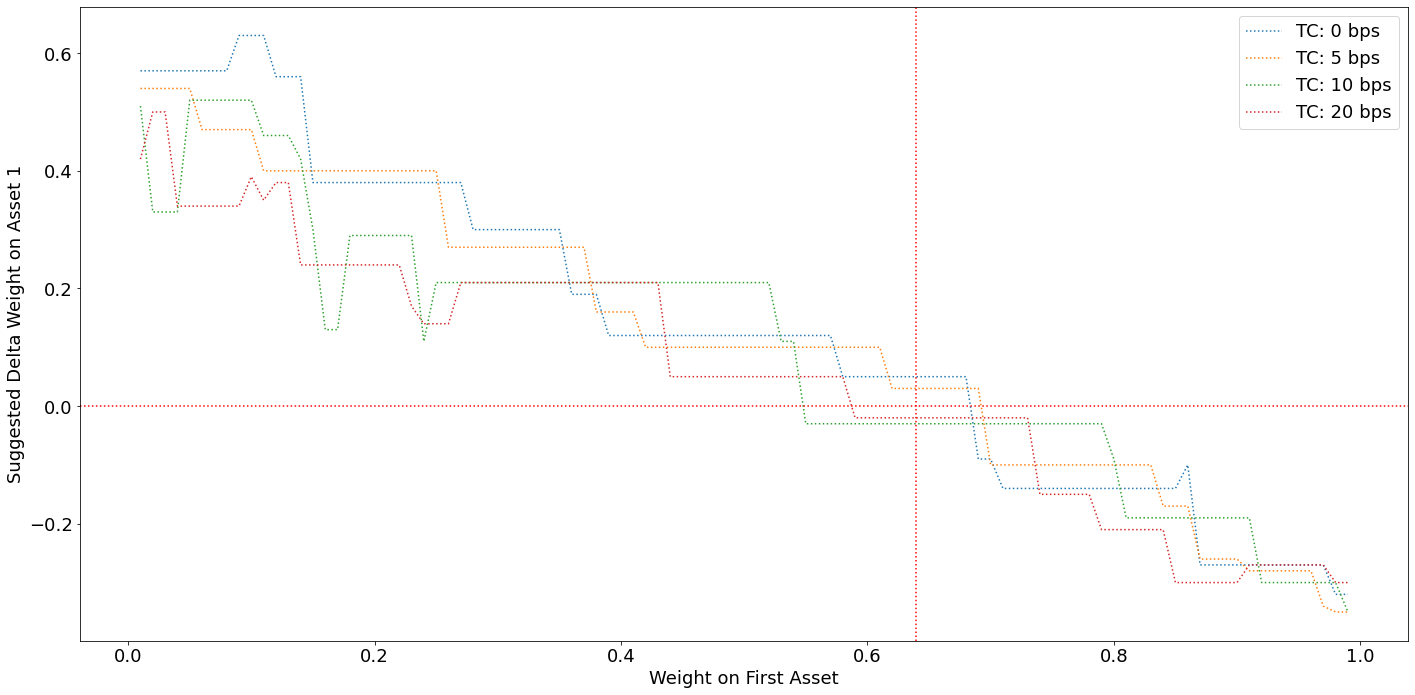

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
# mpl.savefig(os.path.expanduser(f"~/Desktop/bell_qlearn_dqn.png"))
# mpl.close()xx
